# PROJET  – QUESTION 1

Objectif : Construire le meilleur prédicteur possible (MSE)
Données : 100 variables, valeurs manquantes, train + test


### 1. Imports

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression


### 2. Chargement des données

In [15]:
# load data
print("Chargement des données...")
X_train= pd.read_csv(r'C:\Users\spesh\Downloads\data_exo_1\Xtrainmissing.csv')
y_train = pd.read_csv(r'C:\Users\spesh\Downloads\data_exo_1\ytrain.csv')
X_test = pd.read_csv(r'C:\Users\spesh\Downloads\data_exo_1\Xtest.csv')
print("Données chargées avec succès.")

Chargement des données...
Données chargées avec succès.



### 3. Analyse exploratoire

In [16]:
percent_na_total = X_train.isna().sum().sum() / X_train.size * 100
print(f"Pourcentage total de valeurs manquantes : {percent_na_total:.2f}%")


Pourcentage total de valeurs manquantes : 0.99%


In [17]:
# données manquantes

print("Analyse des valeurs manquantes (%)")
print(X_train.isna().mean().mul(100).sort_values(ascending=False))

Analyse des valeurs manquantes (%)
64    1.8
19    1.7
78    1.6
95    1.6
91    1.6
     ... 
14    0.6
85    0.6
79    0.4
21    0.4
27    0.4
Length: 100, dtype: float64


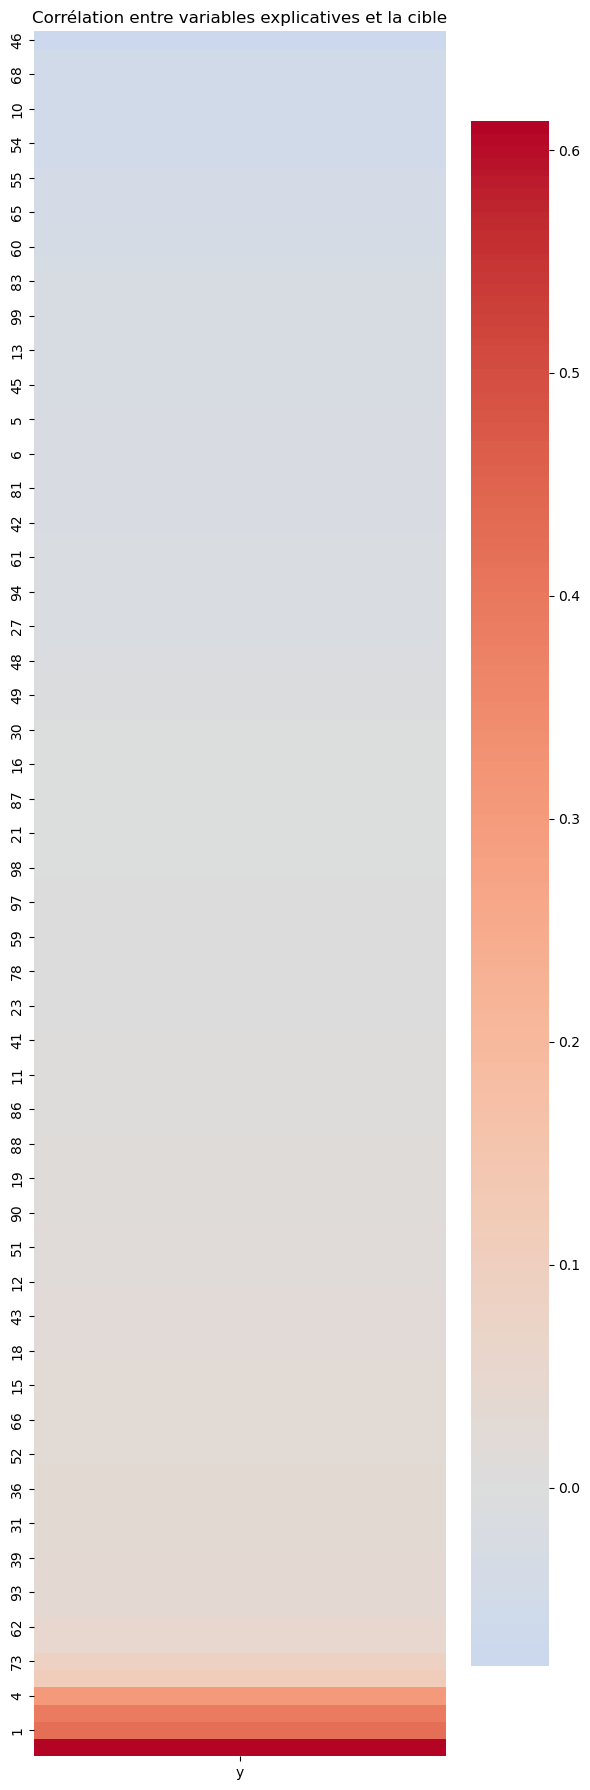

In [18]:
# Corrélation features / cible
df_corr = X_train.copy()
df_corr['y'] = y_train
corr_y = df_corr.corr()['y'].drop('y').sort_values()

plt.figure(figsize=(6, 18))
sns.heatmap(corr_y.to_frame(), cmap='coolwarm', center=0)
plt.title("Corrélation entre variables explicatives et la cible")
plt.tight_layout()
plt.show()


### 4. Pipeline de prétraitement

In [19]:
preprocess = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])



### 5. Modèles et validation croisée

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Ridge 

In [21]:
import numpy as np
ridge_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', Ridge())
])

param_grid_ridge = {
    'model__alpha': np.logspace(-3, 3, 20)
}

In [22]:
gs_ridge = GridSearchCV(
    ridge_pipeline,
    param_grid_ridge,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1
)

gs_ridge.fit(X_train, y_train)

print("Meilleur alpha Ridge :", gs_ridge.best_params_)
print("MSE CV Ridge :", -gs_ridge.best_score_)


Meilleur alpha Ridge : {'model__alpha': 54.555947811685144}
MSE CV Ridge : 7.186507020981584


### Elastic Net

In [23]:
enet_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', ElasticNet(max_iter=10000))
])

param_grid_enet = {
    'model__alpha': np.logspace(-3, 2, 10),
    'model__l1_ratio': [0.1, 0.5, 0.9]
}

gs_enet = GridSearchCV(
    enet_pipeline,
    param_grid_enet,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1
)

gs_enet.fit(X_train, y_train)
print("Meilleurs paramètres Elastic Net :", gs_enet.best_params_)
print("MSE CV Elastic Net :", -gs_enet.best_score_)

Meilleurs paramètres Elastic Net : {'model__alpha': 0.1668100537200059, 'model__l1_ratio': 0.9}
MSE CV Elastic Net : 6.314552151507788


###  Sélection du meilleur modèle  Ridge et Elastic Net


In [24]:

if -gs_enet.best_score_ < -gs_ridge.best_score_:
    best_model = gs_enet.best_estimator_
    print("Elastic Net sélectionné")
else:
    best_model = gs_ridge.best_estimator_
    print("Ridge sélectionné")

Elastic Net sélectionné


### GradientBosting

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
gbr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', GradientBoostingRegressor(random_state=42))
])

param_grid_gbr = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [2, 3]
}

gs_gbr = GridSearchCV(
    gbr_pipeline,
    param_grid_gbr,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1
)

gs_gbr.fit(X_train, y_train)

print("Meilleurs paramètres Gradient Boosting :", gs_gbr.best_params_)
print("MSE CV Gradient Boosting :", -gs_gbr.best_score_)


C:\Users\spesh\OneDrive\Documenten\Logiciel_Python\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Meilleurs paramètres Gradient Boosting : {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
MSE CV Gradient Boosting : 1.782329479714497


In [26]:
print("Résumé MSE (validation croisée)")
print(f"Ridge        : {-gs_ridge.best_score_:.4f}")
print(f"Elastic Net  : {-gs_enet.best_score_:.4f}")
print(f"GradBoosting : {-gs_gbr.best_score_:.4f}")


Résumé MSE (validation croisée)
Ridge        : 7.1865
Elastic Net  : 6.3146
GradBoosting : 1.7823


In [27]:
gs_gbr.best_estimator_.fit(X_train, y_train)
y_pred_test = gs_gbr.best_estimator_.predict(X_test)

pd.DataFrame({'y_pred': y_pred_test}).to_csv("ypred.csv", index=False)


C:\Users\spesh\OneDrive\Documenten\Logiciel_Python\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###  Random_Forest


In [28]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('model', RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

param_grid_rf = {
    'model__n_estimators': [200, 500],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_leaf': [1, 5]
}
gs_rf = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1
)

gs_rf.fit(X_train, y_train)

print("Meilleurs paramètres Random Forest :", gs_rf.best_params_)
print("MSE CV Random Forest :", -gs_rf.best_score_)


C:\Users\spesh\OneDrive\Documenten\Logiciel_Python\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Meilleurs paramètres Random Forest : {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__n_estimators': 500}
MSE CV Random Forest : 4.685069853786432


In [29]:
print("Résumé des MSE (validation croisée)")
print(f"Ridge        : {-gs_ridge.best_score_:.4f}")
print(f"Elastic Net  : {-gs_enet.best_score_:.4f}")
print(f"GradBoosting : {-gs_gbr.best_score_:.4f}")
print(f"RandomForest : {-gs_rf.best_score_:.4f}")


Résumé des MSE (validation croisée)
Ridge        : 7.1865
Elastic Net  : 6.3146
GradBoosting : 1.7823
RandomForest : 4.6851


### Xgboost

In [30]:
from xgboost import XGBRegressor


xgb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ))
])
param_grid_xgb = {
    'model__n_estimators': [200, 400],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [2, 3],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}
gs_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1
)

gs_xgb.fit(X_train, y_train)

print("Meilleurs paramètres XGBoost :", gs_xgb.best_params_)
print("MSE CV XGBoost :", -gs_xgb.best_score_)



Meilleurs paramètres XGBoost : {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 400, 'model__subsample': 0.8}
MSE CV XGBoost : 1.5501646627172345


In [31]:
print("Résumé MSE (validation croisée)")
print(f"Ridge        : {-gs_ridge.best_score_:.4f}")
print(f"Elastic Net  : {-gs_enet.best_score_:.4f}")
print(f"GradBoosting : {-gs_gbr.best_score_:.4f}")
print(f"RandomForest : {-gs_rf.best_score_:.4f}")
print(f"XGBoost      : {-gs_xgb.best_score_:.4f}")


Résumé MSE (validation croisée)
Ridge        : 7.1865
Elastic Net  : 6.3146
GradBoosting : 1.7823
RandomForest : 4.6851
XGBoost      : 1.5502


### 6. Entraînement final et prédictions test

In [34]:
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)

### 7. Sauvegarde du modèle

In [35]:
ypred = pd.DataFrame({'y_pred': y_pred_test})
ypred.to_csv("ypred.csv", index=False)

print("Fichier ypred.csv généré avec succès")

Fichier ypred.csv généré avec succès
